In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

# import required libraries for dataframe and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
import datetime as dt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import required libraries for clustering
import sklearn
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot

In [3]:
from google.colab import files
data_to_load = files.upload()

Saving merged_raw.csv to merged_raw.csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['merged_raw.csv']))

In [5]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1','Is_Diabetic', 'final_IsDia'], axis = 1)
df

,SEQN,Cadmium (ug/L),Lead (ug/dL),Blood manganese (ug/L),"Mercury, total (ug/L)",Blood selenium(ug/L),LDL-Cholesterol,Lymphocyte number,Monocyte number,Segmented neutrophils number,Eosinophils number,Basophils number,Red cell count SI,Hemoglobin (g/dL),Platelet count (%) SI,Glycohemoglobin (%),Insulin (uU/mL),"Total length of ""food fast,"" hours",Two Hour Glucose(OGTT) (mg/dL),Amount of glucose challenge drank,Total # of Dietary Supplements Taken,Total # of Antacids Taken,Any Dietary Supplements Taken?,Any Antacids Taken?,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),Total polyunsaturated fatty acids (gm),Cholesterol (mg),Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (Vitamin B1) (mg),Riboflavin (Vitamin B2) (mg),Niacin (mg),Vitamin B6 (mg),...,Diastolic: Blood pressure (second reading) mm Hg,Weight (kg),Recumbent Length (cm),Height-Length difference flagged,Head Circumference (cm),Body Mass Index (kg/m**2),Arm Circumference (cm),Waist Circumference (cm),Sagittal Abdominal Diameter 1st (cm),Average Sagittal Abdominal Diameter (cm),Grip test status,Dominant hand,Testing position,Combined grip strength (kg),"Grip strength (kg), hand 1, test 1","Grip strength (kg), hand 2, test 1",Overall Oral Health Exam Status,Dentition Status Code,Dental Implant: yes / no?,Tooth Count: Upper right 3rd molar (3M),Coronal Caries: Surface condition #2,Dental Sealants: Upper right 2nd molar (2M) sealant codes,Coronal Caries: Tooth count #2,How often add salt to food at table,Total bottled water drank yesterday (gm),Theobromine (mg),Salmon eaten during past 30 days,Gender,AgeYears,Race,BirthCountry,Citizenship,USStayLength,EduLevelAdult,MaritalStatus,PregnancyStatus,PeopleHH,FamilyIncome,PovertyRatio,is_diabetic
0,73559,0.22,1.45,9.57,1.27,209.64,126.00,1.0,0.80,4.90,0.40,0.10,5.53,17.20,237.00,8.90,5.83,15.0,115.55,1.10,6.75,0.11,1.0,1.91,13.43,3.80,2.78,2.09,2.09,1.88,0.99,0.97,0.98,12.55,831.79,1252.14,28.40,11.28,71.32,40.92,...,76.00,88.9,81.63,175.3,41.57,28.9,33.5,109.2,25.80,25.60,1.00,3.00,1.00,91.00,43.10,45.70,1.0,1.0,2.00,4.00,6.00,5.72,Z,1.00,1254.000000,71.00,1.62,Male,72.0,White,USA,USCitizen,Unknown,College/AA,Married,NotApplicable,2,65-75k,4.51,1
1,73564,0.37,1.00,16.80,0.42,195.62,168.00,1.6,0.30,3.00,0.30,0.00,4.66,13.50,180.00,5.50,14.91,11.0,150.00,1.00,6.40,0.09,1.0,1.92,15.46,4.10,3.09,2.54,2.10,2.03,1.00,0.98,1.01,19.17,891.67,1175.10,21.99,11.44,72.79,24.96,...,80.00,93.4,81.63,161.8,41.57,35.7,38.0,110.8,26.60,26.70,1.00,1.00,1.00,45.90,23.60,16.90,1.0,1.0,2.00,4.00,56789.00,5.72,Z,1.76,0.000000,67.00,2.00,Female,61.0,White,USA,USCitizen,Unknown,College/Above,Widowed,Unknown,1,65-75k,5.00,0
2,73580,0.07,0.31,4.22,0.46,188.00,225.00,1.7,0.50,2.80,0.50,0.10,4.77,13.30,209.00,5.80,10.92,10.0,81.00,1.00,6.86,0.05,1.0,1.93,14.58,3.93,2.87,2.19,2.03,2.00,1.00,0.98,1.01,14.20,931.76,1102.19,30.01,11.07,65.37,25.53,...,66.00,93.5,81.63,161.4,41.57,35.9,43.0,107.4,26.50,26.50,1.00,1.00,1.00,68.20,30.00,32.80,1.0,1.0,2.00,5.00,6.00,5.72,Z,1.00,0.000000,121.00,2.00,Female,38.0,Black,USA,USCitizen,Unknown,HighSchool/GED,Married,NotPregnant,6,>20k,NaN,0
3,73607,0.50,1.35,8.31,0.33,219.00,161.00,2.3,0.60,3.80,0.10,0.00,4.16,13.50,152.00,5.00,17.47,13.0,113.00,1.00,6.31,0.10,1.0,1.86,14.79,3.96,3.66,3.08,2.16,1.97,1.00,0.99,1.00,14.82,841.43,1132.39,24.57,12.55,90.60,52.14,...,84.00,111.9,81.63,169.6,41.57,38.9,38.5,130.5,30.80,31.00,1.00,1.00,1.00,67.30,34.60,28.10,1.0,1.0,2.00,4.00,8535.09,5.72,P,1.75,0.000000,0.00,1.68,Male,75.0,White,USA,USCitizen,Unknown,HighSchool/GED,Married,NotApplicable,2,15-20k,1.08,0
4,73621,0.36,1.38,8.14,0.87,212.84,161.00,0.8,0.40,2.80,0.10,0.00,4.55,13.80,197.00,5.60,4.33,15.0,97.00,1.00,6.23,0.13,1.0,1.91,14.29,3.77,3.59,3.04,2.18,1.91,0.99,0.98,0.99,12.71,820.50,1072.40,23.71,12.54,80.34,84.59,...,66.00,76.4,81.63,176.2,41.57,24.6,29.6,98.2,21.50,21.50,1.00,1.00,1.00,61.20,34.10,

In [6]:
cols = df.columns.tolist()
print(cols)

['SEQN', 'Cadmium (ug/L)', 'Lead (ug/dL)', 'Blood manganese (ug/L)', 'Mercury, total (ug/L)', 'Blood selenium(ug/L)', 'LDL-Cholesterol', 'Lymphocyte number', 'Monocyte number', 'Segmented neutrophils number', 'Eosinophils number', 'Basophils number', 'Red cell count SI', 'Hemoglobin (g/dL)', 'Platelet count (%) SI', 'Glycohemoglobin (%)', 'Insulin (uU/mL)', 'Total length of "food fast," hours', 'Two Hour Glucose(OGTT) (mg/dL)', 'Amount of glucose challenge drank', 'Total # of Dietary Supplements Taken', 'Total # of Antacids Taken', 'Any Dietary Supplements Taken?', 'Any Antacids Taken?', 'Energy (kcal)', 'Protein (gm)', 'Carbohydrate (gm)', 'Total sugars (gm)', 'Dietary fiber (gm)', 'Total fat (gm)', 'Total saturated fatty acids (gm)', 'Total monounsaturated fatty acids (gm)', 'Total polyunsaturated fatty acids (gm)', 'Cholesterol (mg)', 'Lycopene (mcg)', 'Lutein + zeaxanthin (mcg)', 'Thiamin (Vitamin B1) (mg)', 'Riboflavin (Vitamin B2) (mg)', 'Niacin (mg)', 'Vitamin B6 (mg)', 'Folic a

In [7]:
df.corr()

,SEQN,Cadmium (ug/L),Lead (ug/dL),Blood manganese (ug/L),"Mercury, total (ug/L)",Blood selenium(ug/L),LDL-Cholesterol,Lymphocyte number,Monocyte number,Segmented neutrophils number,Eosinophils number,Basophils number,Red cell count SI,Hemoglobin (g/dL),Platelet count (%) SI,Glycohemoglobin (%),Insulin (uU/mL),"Total length of ""food fast,"" hours",Two Hour Glucose(OGTT) (mg/dL),Amount of glucose challenge drank,Total # of Dietary Supplements Taken,Total # of Antacids Taken,Any Dietary Supplements Taken?,Any Antacids Taken?,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),Total polyunsaturated fatty acids (gm),Cholesterol (mg),Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (Vitamin B1) (mg),Riboflavin (Vitamin B2) (mg),Niacin (mg),Vitamin B6 (mg),...,Iron (mg),Zinc (mg),Copper (mg),Sodium (mg),Potassium (mg),Selenium (mcg),Caffeine (mg),Iodine (mcg),Blood Pressure Status,Systolic: Blood pressure (first reading) mm Hg,Diastolic: Blood pressure (second reading) mm Hg,Weight (kg),Recumbent Length (cm),Height-Length difference flagged,Head Circumference (cm),Body Mass Index (kg/m**2),Arm Circumference (cm),Waist Circumference (cm),Sagittal Abdominal Diameter 1st (cm),Average Sagittal Abdominal Diameter (cm),Grip test status,Dominant hand,Testing position,Combined grip strength (kg),"Grip strength (kg), hand 1, test 1","Grip strength (kg), hand 2, test 1",Overall Oral Health Exam Status,Dentition Status Code,Dental Implant: yes / no?,Tooth Count: Upper right 3rd molar (3M),Coronal Caries: Surface condition #2,Dental Sealants: Upper right 2nd molar (2M) sealant codes,How often add salt to food at table,Total bottled water drank yesterday (gm),Theobromine (mg),Salmon eaten during past 30 days,AgeYears,PeopleHH,PovertyRatio,is_diabetic
SEQN,1.000000,0.337509,0.221079,-0.037562,0.100243,-0.037804,0.025383,0.116157,0.007058,-0.034649,0.023298,-0.000324,0.005771,0.048291,0.024670,0.106520,0.018099,0.036057,0.130279,0.069500,-0.014968,0.006877,-0.003725,-0.015203,-0.017818,0.029272,-0.068438,-0.104759,-0.086990,-0.044097,-0.030381,-0.045073,-0.030344,0.014366,-0.010136,0.022832,0.007523,-0.002003,-0.098198,-0.022308,...,0.057040,0.002303,-0.115272,-0.009885,0.050416,-0.013164,0.008170,0.042391,-0.020093,-0.011994,-0.014698,-0.028174,0.006011,-0.007431,0.010478,-0.037958,-0.021334,-0.032855,-0.033980,-0.033804,-0.006552,0.001167,-0.009139,-0.011358,-0.010806,-0.016309,-0.010572,0.002607,-0.020715,0.002648,-0.012540,-0.018639,0.029537,0.014407,0.013732,0.013362,-0.007598,0.018854,0.001373,-0.024495
Cadmium (ug/L),0.337509,1.000000,0.400215,0.144822,0.268445,0.188371,0.366479,0.148418,0.082712,0.132766,0.135616,0.319771,-0.084291,-0.032223,0.302439,0.130116,-0.033352,0.215914,0.171954,0.138219,-0.080986,-0.002047,0.010524,-0.012667,-0.024681,0.040595,-0.115420,-0.280535,-0.181453,-0.051607,-0.083841,0.027131,-0.047433,-0.055628,-0.081795,0.039776,-0.086325,-0.068799,-0.294844,-0.141315,...,-0.073813,-0.077469,-0.311525,-0.054649,-0.085604,-0.233899,-0.308807,-0.102821,-0.005889,0.038443,0.026194,-0.068712,0.005603,-0.064519,0.001640,-0.048676,-0.064718,-0.041796,-0.006822,-0.006434,-0.008809,0.003674,-0.004287,-0.058041,-0.056171,-0.052606,0.012600,0.007433,-0.007282,0.034664,0.013728,0.105770,0.026070,-0.027366,0.031273,0.025515,0.045327,-0.053023,-0.016187,-0.008131
Lead (ug/dL),0.221079,0.400215,1.000000,-0.005756,0.249669,0.078621,0.258277,-0.005486,0.107934,0.019439,0.111600,0.169411,0.001502,0.079758,0.048929,0.168102,-0.092124,0.155543,0.166079,0.095036,-0.068563,0.001867,0.009731,-0.016246,-0.016408,0.024611,-0.063010,-0.156665,-0.099952,-0.019884,-0.043382,0.021999,-0.042870,-0.057193,-0.053504,0.036776,-0.032793,-0.045054,-0.187846,-0.056047,...,-0.051599,-0.056035,-0.218767,-0.033243,-0.036326,-0.128184,-0.138236,-0.062969,-0.010436,0.073493,0.025613,-0.042284,0.004905,-0.012079,0.000775,-0.052002,-0.044662,-0.0

In [8]:
df_with_dummies = pd.get_dummies(df)
df_with_dummies

,SEQN,Cadmium (ug/L),Lead (ug/dL),Blood manganese (ug/L),"Mercury, total (ug/L)",Blood selenium(ug/L),LDL-Cholesterol,Lymphocyte number,Monocyte number,Segmented neutrophils number,Eosinophils number,Basophils number,Red cell count SI,Hemoglobin (g/dL),Platelet count (%) SI,Glycohemoglobin (%),Insulin (uU/mL),"Total length of ""food fast,"" hours",Two Hour Glucose(OGTT) (mg/dL),Amount of glucose challenge drank,Total # of Dietary Supplements Taken,Total # of Antacids Taken,Any Dietary Supplements Taken?,Any Antacids Taken?,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),Total polyunsaturated fatty acids (gm),Cholesterol (mg),Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (Vitamin B1) (mg),Riboflavin (Vitamin B2) (mg),Niacin (mg),Vitamin B6 (mg),...,EduLevelAdult_>HighSchool,EduLevelAdult_College/AA,EduLevelAdult_College/Above,EduLevelAdult_DontKnow,EduLevelAdult_GED,EduLevelAdult_HighSchool,EduLevelAdult_HighSchool/GED,EduLevelAdult_NoEdu/KG,EduLevelAdult_Refused,EduLevelAdult_Unknown,MaritalStatus_Divorced,MaritalStatus_DontKnow,MaritalStatus_LivingIn,MaritalStatus_Married,MaritalStatus_NeverMarried,MaritalStatus_Refused,MaritalStatus_Separated,MaritalStatus_Unknown,MaritalStatus_Widowed,PregnancyStatus_CannotTell,PregnancyStatus_NotApplicable,PregnancyStatus_NotPregnant,PregnancyStatus_Pregnant,PregnancyStatus_Unknown,FamilyIncome_10-15k,FamilyIncome_15-20k,FamilyIncome_20-25k,FamilyIncome_25-35k,FamilyIncome_35-45k,FamilyIncome_45-55k,FamilyIncome_5-10k,FamilyIncome_55-65k,FamilyIncome_65-75k,FamilyIncome_75-99k,FamilyIncome_<20k,FamilyIncome_<5k,FamilyIncome_>100k,FamilyIncome_>20k,FamilyIncome_DontKnow,FamilyIncome_Refused
0,73559,0.22,1.45,9.57,1.27,209.64,126.00,1.0,0.80,4.90,0.40,0.10,5.53,17.20,237.00,8.90,5.83,15.0,115.55,1.10,6.75,0.11,1.0,1.91,13.43,3.80,2.78,2.09,2.09,1.88,0.99,0.97,0.98,12.55,831.79,1252.14,28.40,11.28,71.32,40.92,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,73564,0.37,1.00,16.80,0.42,195.62,168.00,1.6,0.30,3.00,0.30,0.00,4.66,13.50,180.00,5.50,14.91,11.0,150.00,1.00,6.40,0.09,1.0,1.92,15.46,4.10,3.09,2.54,2.10,2.03,1.00,0.98,1.01,19.17,891.67,1175.10,21.99,11.44,72.79,24.96,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,73580,0.07,0.31,4.22,0.46,188.00,225.00,1.7,0.50,2.80,0.50,0.10,4.77,13.30,209.00,5.80,10.92,10.0,81.00,1.00,6.86,0.05,1.0,1.93,14.58,3.93,2.87,2.19,2.03,2.00,1.00,0.98,1.01,14.20,931.76,1102.19,30.01,11.07,65.37,25.53,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,73607,0.50,1.35,8.31,0.33,219.00,161.00,2.3,0.60,3.80,0.10,0.00,4.16,13.50,152.00,5.00,17.47,13.0,113.00,1.00,6.31,0.10,1.0,1.86,14.79,3.96,3.66,3.08,2.16,1.97,1.00,0.99,1.00,14.82,841.43,1132.39,24.57,12.55,90.60,52.14,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,73621,0.36,1.38,8.14,0.87,212.84,161.00,0.8,0.40,2.80,0.10,0.00,4.55,13.80,197.00,5.60,4.33,15.0,97.00,1.00,6.23,0.13,1.0,1.91,14.29,3.77,3.59,3.04,2.18,1.91,0.99,0.98,0.99,12.71,820.50,1072.40,23.71,12.54,80.34,84.59,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9887,83718,0.79,1.62,11.19,2.41,205.41,222.35,2.2,0.54,3.93,0.23,0.05,4.62,13.77,275.26,5.96,12.25,12.3,138.70,1.16,2.00,0.00,1.0,2.00,14.00,4.00,3.00,2.00,2.00,2.00,1.00,1.00,1.00,12.00,652.00,1042.00,14.00,7.00,29.00,11.00,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9888,83721,0.79,1.62,11.19,2.41,205.41,222.35,2.2,0.54,3.

In [9]:
df_with_dummies = df_with_dummies.dropna()
df_with_dummies

,SEQN,Cadmium (ug/L),Lead (ug/dL),Blood manganese (ug/L),"Mercury, total (ug/L)",Blood selenium(ug/L),LDL-Cholesterol,Lymphocyte number,Monocyte number,Segmented neutrophils number,Eosinophils number,Basophils number,Red cell count SI,Hemoglobin (g/dL),Platelet count (%) SI,Glycohemoglobin (%),Insulin (uU/mL),"Total length of ""food fast,"" hours",Two Hour Glucose(OGTT) (mg/dL),Amount of glucose challenge drank,Total # of Dietary Supplements Taken,Total # of Antacids Taken,Any Dietary Supplements Taken?,Any Antacids Taken?,Energy (kcal),Protein (gm),Carbohydrate (gm),Total sugars (gm),Dietary fiber (gm),Total fat (gm),Total saturated fatty acids (gm),Total monounsaturated fatty acids (gm),Total polyunsaturated fatty acids (gm),Cholesterol (mg),Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (Vitamin B1) (mg),Riboflavin (Vitamin B2) (mg),Niacin (mg),Vitamin B6 (mg),...,EduLevelAdult_>HighSchool,EduLevelAdult_College/AA,EduLevelAdult_College/Above,EduLevelAdult_DontKnow,EduLevelAdult_GED,EduLevelAdult_HighSchool,EduLevelAdult_HighSchool/GED,EduLevelAdult_NoEdu/KG,EduLevelAdult_Refused,EduLevelAdult_Unknown,MaritalStatus_Divorced,MaritalStatus_DontKnow,MaritalStatus_LivingIn,MaritalStatus_Married,MaritalStatus_NeverMarried,MaritalStatus_Refused,MaritalStatus_Separated,MaritalStatus_Unknown,MaritalStatus_Widowed,PregnancyStatus_CannotTell,PregnancyStatus_NotApplicable,PregnancyStatus_NotPregnant,PregnancyStatus_Pregnant,PregnancyStatus_Unknown,FamilyIncome_10-15k,FamilyIncome_15-20k,FamilyIncome_20-25k,FamilyIncome_25-35k,FamilyIncome_35-45k,FamilyIncome_45-55k,FamilyIncome_5-10k,FamilyIncome_55-65k,FamilyIncome_65-75k,FamilyIncome_75-99k,FamilyIncome_<20k,FamilyIncome_<5k,FamilyIncome_>100k,FamilyIncome_>20k,FamilyIncome_DontKnow,FamilyIncome_Refused
0,73559,0.22,1.45,9.57,1.27,209.64,126.00,1.0,0.80,4.90,0.40,0.10,5.53,17.20,237.00,8.90,5.83,15.0,115.55,1.10,6.75,0.11,1.0,1.91,13.43,3.80,2.78,2.09,2.09,1.88,0.99,0.97,0.98,12.55,831.79,1252.14,28.40,11.28,71.32,40.92,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,73564,0.37,1.00,16.80,0.42,195.62,168.00,1.6,0.30,3.00,0.30,0.00,4.66,13.50,180.00,5.50,14.91,11.0,150.00,1.00,6.40,0.09,1.0,1.92,15.46,4.10,3.09,2.54,2.10,2.03,1.00,0.98,1.01,19.17,891.67,1175.10,21.99,11.44,72.79,24.96,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,73607,0.50,1.35,8.31,0.33,219.00,161.00,2.3,0.60,3.80,0.10,0.00,4.16,13.50,152.00,5.00,17.47,13.0,113.00,1.00,6.31,0.10,1.0,1.86,14.79,3.96,3.66,3.08,2.16,1.97,1.00,0.99,1.00,14.82,841.43,1132.39,24.57,12.55,90.60,52.14,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,73621,0.36,1.38,8.14,0.87,212.84,161.00,0.8,0.40,2.80,0.10,0.00,4.55,13.80,197.00,5.60,4.33,15.0,97.00,1.00,6.23,0.13,1.0,1.91,14.29,3.77,3.59,3.04,2.18,1.91,0.99,0.98,0.99,12.71,820.50,1072.40,23.71,12.54,80.34,84.59,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,73633,0.07,0.59,9.62,0.20,168.49,195.00,2.1,0.50,5.00,0.10,0.10,4.37,13.80,210.00,5.20,12.06,13.0,124.00,1.00,6.74,0.08,1.0,1.90,15.56,3.82,3.57,3.63,2.23,1.88,0.98,0.98,0.99,13.32,862.73,1070.10,25.90,13.98,73.97,28.77,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,83717,0.79,1.62,11.19,2.41,205.41,222.35,2.2,0.54,3.93,0.23,0.05,4.62,13.77,275.26,5.96,12.25,12.3,138.70,1.16,2.00,0.00,1.0,2.00,14.00,4.00,3.00,2.00,2.00,2.00,1.00,1.00,1.00,12.00,652.00,1042.00,14.00,7.00,29.00,11.00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9888,83721,0.79,1.62,11.19,2.41,205.41,222.35,2.2,0.54,3

In [10]:
# create X and y

X_unscaled = df_with_dummies.drop(['is_diabetic','SEQN'], axis = 1)
y = df_with_dummies['is_diabetic']

#scale X for faster convergance

scaler = StandardScaler()

X = scaler.fit_transform(X_unscaled)


#train and test split

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size =0.3, random_state = 42, stratify = y)


# C values for lasso penalty

C_values = [0.001, 0.01, 0.1,0.3, 0.5, 1]

tree_depth = list(range(2, 50))

### Linear SVC

In [11]:
# Build Model

accuracies = []

for C in C_values:
    lsvc = LinearSVC(C=C, penalty="l1", dual = False).fit(X_train, y_train)
    y_preds = lsvc.predict(X_test)
    accuracies.append(accuracy_score(y_test,y_preds))

c_ideal = C_values[np.argmax(accuracies)]
print ('C: ',c_ideal)

lsvc = LinearSVC(C=0.01, penalty="l1", dual = False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_new = model.transform(X_train)
y_preds = lsvc.predict(X_test)

print ('shape original: ', X_train.shape)
print ('shape transformed: ', X_train_new.shape)

print('Linear SVC Test Accuracy Score: ', accuracy_score(y_test,y_preds))



scores = model_selection.cross_val_score(lsvc, X, y, cv=10)
print(scores)
print('Linear SVC average score: {}'.format(scores.mean()))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



C:  0.01


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



shape original:  (6279, 182)
shape transformed:  (6279, 84)
Linear SVC Test Accuracy Score:  0.8001485884101041


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[0.78841871 0.81270903 0.75027871 0.78929766 0.75585284 0.75585284
 0.81939799 0.80713489 0.80824972 0.79264214]
Linear SVC average score: 0.78798345387868


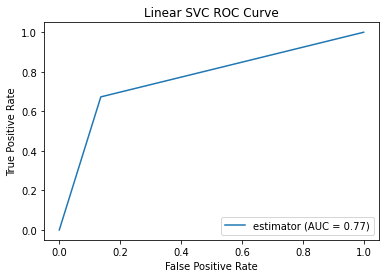

In [12]:
#ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='estimator')
display.plot()
plt.title("Linear SVC ROC Curve")
plt.show()

In [13]:
#Features used
importance_lsvc = lsvc.coef_[0]
cols_new = X_unscaled.columns.tolist()
importance_index_lsvc = np.nonzero(importance_lsvc)[0]

for i in importance_index_lsvc:
    print(cols_new[i], ': ', importance_lsvc[i])

Cadmium (ug/L) :  -0.022297297831234263
Blood manganese (ug/L) :  -0.0269633109877591
Blood selenium(ug/L) :  0.008778381280103427
Lymphocyte number :  0.009568666619662243
Basophils number :  -0.02215193626616282
Hemoglobin (g/dL) :  -0.036140964344155396
Platelet count (%) SI :  -0.0910109855057404
Glycohemoglobin (%) :  0.13846310297748837
Insulin (uU/mL) :  0.009866936325164779
Total length of "food fast," hours :  0.002988169128079268
Two Hour Glucose(OGTT) (mg/dL) :  0.012479071442294282
Amount of glucose challenge drank :  -0.013379840911676353
Total # of Dietary Supplements Taken :  0.00950106892551664
Total # of Antacids Taken :  0.0003975874124360174
Any Dietary Supplements Taken? :  -0.023591982941171524
Any Antacids Taken? :  0.0038406456545915387
Protein (gm) :  -0.011126043152353897
Total sugars (gm) :  -0.07125681387485726
Total polyunsaturated fatty acids (gm) :  -0.002854439171605493
Cholesterol (mg) :  -0.03826022854296037
Thiamin (Vitamin B1) (mg) :  -0.0070857228860

In [14]:
#Rank Features
for importance, name in sorted(zip(lsvc.coef_[0], X_unscaled.columns),reverse=True)[:20]:
    print (name, importance)

AgeYears 0.45714012155606726
Glycohemoglobin (%) 0.13846310297748837
Average Sagittal Abdominal Diameter (cm) 0.06434433813408813
Potassium (mg) 0.05931600186568361
Waist Circumference (cm) 0.04881895586569688
Citizenship_USCitizen 0.04190524528381219
Vitamin D (D2 + D3) (mcg) 0.037523167177757735
Sagittal Abdominal Diameter 1st (cm) 0.03627375134253993
Iron (mg) 0.03394462727542947
PregnancyStatus_Unknown 0.02775560123463907
Coronal Caries: Tooth count #2_P 0.0276729101133537
Dental Sealants: Upper right 2nd molar (2M) sealant codes 0.022439989952651986
EduLevelAdult_College/AA 0.01984573163337498
FamilyIncome_75-99k 0.017647310776103382
Body Mass Index (kg/m**2) 0.0169405705739734
Two Hour Glucose(OGTT) (mg/dL) 0.012479071442294282
USStayLength_15-20 0.01189632830574726
Overall Oral Health Exam Status 0.011661379262989751
PovertyRatio 0.01165579618680335
Salmon eaten during past 30 days 0.010449748223518737


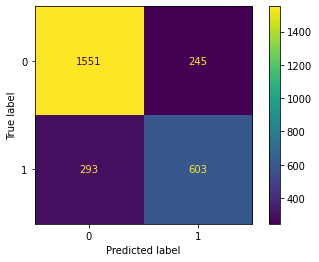

In [15]:
#Confusion Matrix display
cm_lsvc = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lsvc,
                              display_labels=lsvc.classes_)
disp.plot()

plt.show()

#### Logistic Regression

In [18]:
#Build Model


accuracies = []

for C in C_values:
    lr = LogisticRegression(C=C, penalty="l1", dual = False, solver='liblinear').fit(X_train, y_train)
    y_preds = lr.predict(X_test)
    accuracies.append(accuracy_score(y_test,y_preds))

c_ideal = C_values[np.argmax(accuracies)]
print ('C: ',c_ideal)

lr = LogisticRegression(C=c_ideal, penalty="l1", dual = False, solver='liblinear').fit(X_train, y_train)
model = SelectFromModel(lr, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)
y_preds = lr.predict(X_test)

print ('shape original: ', X_train.shape)
print ('shape transformed: ', X_train_new.shape)
print('Logistic Regression Test Accuracy: ',accuracy_score(y_test,y_preds))


scores = model_selection.cross_val_score(lr, X, y, cv=10)
print(scores)
print('Logistic Regression average score: {}'.format(scores.mean()))

C:  0.1
shape original:  (6279, 182)
shape transformed:  (6279, 123)
Logistic Regression Test Accuracy:  0.7975482912332839
[0.78285078 0.81047938 0.73913043 0.78372352 0.75027871 0.74247492
 0.8115942  0.80044593 0.7993311  0.77703456]
Logistic Regression average score: 0.779734353313321


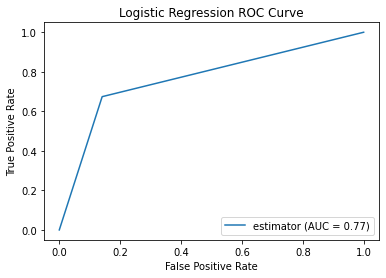

In [19]:
#ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='estimator')
display.plot()
plt.title("Logistic Regression ROC Curve")

plt.show()

In [20]:
#Features Used

importance_lr = lr.coef_[0]
cols_new = X_unscaled.columns.tolist()
importance_index_lr = np.nonzero(importance_lr)[0]

for i in importance_index_lr:
    print(cols_new[i], ': ', importance_lr[i])

Cadmium (ug/L) :  -0.07291722652515677
Lead (ug/dL) :  0.007535214503973743
Blood manganese (ug/L) :  -0.10784503862712465
Blood selenium(ug/L) :  0.048023243111420394
LDL-Cholesterol :  -0.01543880583532306
Lymphocyte number :  0.05215102626690082
Segmented neutrophils number :  0.005837665070008754
Eosinophils number :  -0.005889619203631953
Basophils number :  -0.06161054089259568
Red cell count SI :  0.020213860534424404
Hemoglobin (g/dL) :  -0.15345422343801043
Platelet count (%) SI :  -0.28657117620998873
Glycohemoglobin (%) :  0.4449840156889015
Insulin (uU/mL) :  0.08135150179548364
Total length of "food fast," hours :  0.05198461374472352
Two Hour Glucose(OGTT) (mg/dL) :  0.060641944875912485
Amount of glucose challenge drank :  -0.060719779408872986
Total # of Dietary Supplements Taken :  0.021482334509720064
Total # of Antacids Taken :  0.011580562448538953
Any Dietary Supplements Taken? :  -0.06851771294196449
Any Antacids Taken? :  0.020183390724137936
Energy (kcal) :  0.0

In [21]:
#Rank Features
for importance, name in sorted(zip(lr.coef_[0], X_unscaled.columns),reverse=True)[:20]:
    print (name, importance)

AgeYears 1.3778445713275644
Glycohemoglobin (%) 0.4449840156889015
Waist Circumference (cm) 0.31568343806189025
Potassium (mg) 0.19583935757851048
Vitamin D (D2 + D3) (mcg) 0.13719041280245667
Dental Sealants: Upper right 2nd molar (2M) sealant codes 0.1368108368340238
Weight (kg) 0.13340478011031306
Citizenship_USCitizen 0.1309873942454484
PregnancyStatus_Unknown 0.1275790666574446
Iron (mg) 0.1241314296126419
Sagittal Abdominal Diameter 1st (cm) 0.11732533713201296
MaritalStatus_Married 0.10954926469449933
Carbohydrate (gm) 0.09714363383895765
Overall Oral Health Exam Status 0.08866162345183247
EduLevelAdult_College/AA 0.08560486109497539
MaritalStatus_Divorced 0.08420006308777778
Insulin (uU/mL) 0.08135150179548364
USStayLength_15-20 0.071358202298099
EduLevelAdult_3Grade 0.06994889068058541
Coronal Caries: Tooth count #2_P 0.06930416363861323


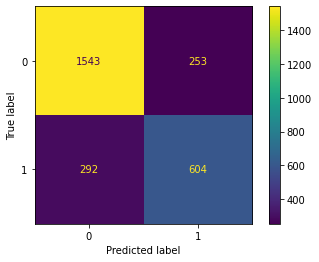

In [22]:
#Confusion Matrix

cm_lr = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                              display_labels=lr.classes_)
disp.plot()

plt.show()

### Decision Tree


In [24]:

# Build Model
       
accuracies = []

for d in tree_depth:
    dtc = DecisionTreeClassifier(max_depth = d,random_state=42).fit(X_train,y_train)
    y_preds = dtc.predict(X_test)
    accuracies.append(accuracy_score(y_test,y_preds))

ideal_d = tree_depth[np.argmax(accuracies)]
print ('Ideal Tree Depth: ', ideal_d)
       
dtc = DecisionTreeClassifier(max_depth = ideal_d,random_state=42).fit(X_train,y_train)
model = SelectFromModel(dtc, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)


# predict
y_preds = dtc.predict(X_test)

print ('shape original: ', X_train.shape)
print ('shape transformed: ', X_train_new.shape)
print('Decision Tree Test Accuracy: ',accuracy_score(y_test,y_preds))


scores = model_selection.cross_val_score(dtc, X, y, cv=10)
print(scores)
print('Decision Tree average score: {}'.format(scores.mean()))

Ideal Tree Depth:  7
shape original:  (6279, 182)
shape transformed:  (6279, 19)
Decision Tree Test Accuracy:  0.7986627043090639
[0.78173719 0.81270903 0.74804905 0.6432553  0.57079153 0.59977703
 0.63322185 0.7212932  0.76031215 0.73801561]
Decision Tree average score: 0.70091619429278


[Text(488.25, 764.4375, 'AgeYears <= 0.131\ngini = 0.444\nsamples = 100.0%\nvalue = [0.667, 0.333]\nclass = ['),
 Text(170.61923076923077, 662.5125, 'AgeYears <= -0.41\ngini = 0.152\nsamples = 50.3%\nvalue = [0.917, 0.083]\nclass = ['),
 Text(64.38461538461539, 560.5875, 'Glycohemoglobin (%) <= 2.741\ngini = 0.054\nsamples = 36.2%\nvalue = [0.972, 0.028]\nclass = ['),
 Text(55.8, 458.66249999999997, 'Body Mass Index (kg/m**2) <= 2.768\ngini = 0.051\nsamples = 36.1%\nvalue = [0.974, 0.026]\nclass = ['),
 Text(34.33846153846154, 356.7375, 'Lead (ug/dL) <= 10.541\ngini = 0.044\nsamples = 35.8%\nvalue = [0.978, 0.022]\nclass = ['),
 Text(25.753846153846155, 254.8125, 'Two Hour Glucose(OGTT) (mg/dL) <= 4.441\ngini = 0.043\nsamples = 35.7%\nvalue = [0.978, 0.022]\nclass = ['),
 Text(17.16923076923077, 152.88750000000005, 'USStayLength_30-40 <= 2.567\ngini = 0.042\nsamples = 35.7%\nvalue = [0.979, 0.021]\nclass = ['),
 Text(8.584615384615384, 50.96249999999998, 'gini = 0.04\nsamples = 35.7%\n

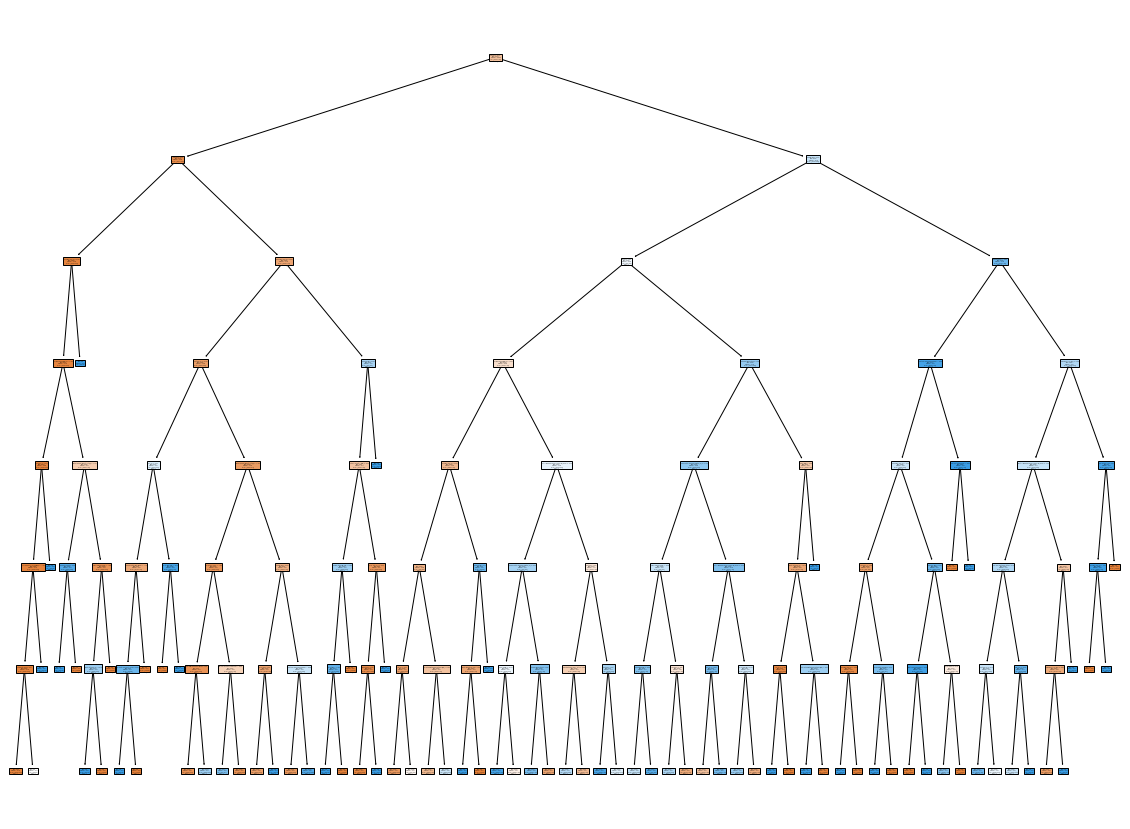

In [25]:
#Plot Tree

cn = list(str(df['is_diabetic'].unique()))
fn = list(X_unscaled.columns)

plt.figure(figsize = (20,15))

plot_tree(dtc, feature_names = fn, class_names = cn, filled = True, proportion=True)

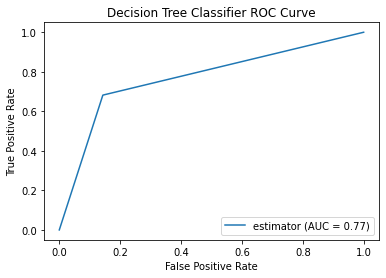

In [26]:
#ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='estimator')
display.plot()

plt.title("Decision Tree Classifier ROC Curve")

plt.show()

In [27]:
#Rank Features

for importance, name in sorted(zip(dtc.feature_importances_, X_unscaled.columns),reverse=True)[:20]:
    print (name, importance)

AgeYears 0.6213960517739525
Potassium (mg) 0.06225011300618419
Glycohemoglobin (%) 0.04524702593010846
Body Mass Index (kg/m**2) 0.029746871967023022
Basophils number 0.02376390320594706
Diastolic: Blood pressure (second reading) mm Hg 0.01829381874220884
Amount of glucose challenge drank 0.016879232141392152
Selenium (mcg) 0.016165457844177975
Weight (kg) 0.012501048000838075
Average Sagittal Abdominal Diameter (cm) 0.010164565193697506
Cholesterol (mg) 0.009052404794428804
Lead (ug/dL) 0.009012792519492404
Citizenship_NonUSCitizen 0.008523537990874228
Vitamin D (D2 + D3) (mcg) 0.008440486301984025
Zinc (mg) 0.007977113631979277
Arm Circumference (cm) 0.007787537877231673
Sagittal Abdominal Diameter 1st (cm) 0.007561933157222154
Grip strength (kg), hand 1, test 1 0.00733984508957541
Total bottled water drank yesterday (gm) 0.007112434827680413
Phosphorus (mg) 0.0044773972310521515


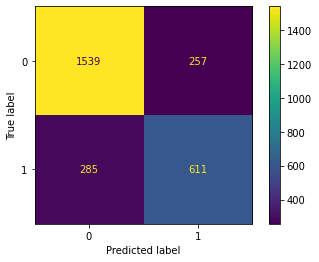

In [28]:
#Confusion Matrix

cm_dtc = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc,
                              display_labels=dtc.classes_)
disp.plot()

plt.show()

### Random Forest

In [30]:
# Build Model
       
accuracies = []

for d in tree_depth:
    rf = RandomForestClassifier(max_depth = d,random_state=42).fit(X_train,y_train)
    y_preds = rf.predict(X_test)
    accuracies.append(accuracy_score(y_test,y_preds))

ideal_d = tree_depth[np.argmax(accuracies)]
print ('Ideal Tree Depth: ', ideal_d)
       
rf = RandomForestClassifier(max_depth = ideal_d,random_state=42).fit(X_train,y_train)
model = SelectFromModel(dtc, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)


# predict
y_preds = rf.predict(X_test)

print ('shape original: ', X_train.shape)
print ('shape transformed: ', X_train_new.shape)
print('Random Forest Test Accuracy: ',accuracy_score(y_test,y_preds))


scores = model_selection.cross_val_score(rf, X, y, cv=10)
print(scores)
print('Random Forest average score: {}'.format(scores.mean()))

Ideal Tree Depth:  31
shape original:  (6279, 182)
shape transformed:  (6279, 19)
Random Forest Test Accuracy:  0.8268945022288261
[0.84855234 0.84949833 0.76142698 0.58862876 0.46265329 0.50167224
 0.5206243  0.54180602 0.66555184 0.75696767]
Random Forest average score: 0.6497381769968193


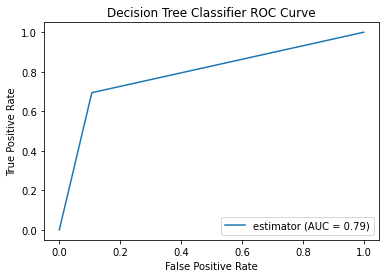

In [32]:
#ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='estimator')
display.plot()

plt.title("Decision Tree Classifier ROC Curve")

plt.show()

In [33]:
#Rank Features

for importance, name in sorted(zip(rf.feature_importances_, X_unscaled.columns),reverse=True)[:20]:
    print (name, importance)

AgeYears 0.11799927381777378
Dental Implant: yes / no? 0.028269654793933157
Waist Circumference (cm) 0.024114821775706966
MaritalStatus_Unknown 0.022630452238685247
Body Mass Index (kg/m**2) 0.022422669427539246
Average Sagittal Abdominal Diameter (cm) 0.022360899450321763
Weight (kg) 0.021933629269295936
Systolic: Blood pressure (first reading) mm Hg 0.0211859921304754
Sagittal Abdominal Diameter 1st (cm) 0.021108011918575552
Glycohemoglobin (%) 0.019447692603489747
Arm Circumference (cm) 0.01592764632983595
Blood manganese (ug/L) 0.015869129684275132
Diastolic: Blood pressure (second reading) mm Hg 0.01585948458925922
Platelet count (%) SI 0.015642424978499925
Combined grip strength (kg) 0.015573388503057332
Grip strength (kg), hand 2, test 1 0.015393941525117583
Potassium (mg) 0.015258633396186251
PeopleHH 0.015226979631954646
Grip strength (kg), hand 1, test 1 0.014729929494666885
Height-Length difference flagged 0.014247924427956107


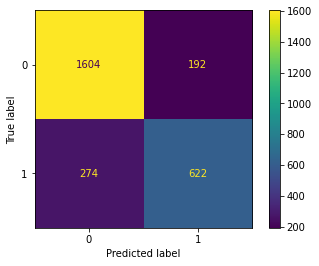

In [44]:
#Confusion Matrix

cm_rf = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=rf.classes_)
disp.plot()

plt.show()

#### XGBoost

In [35]:
xg_clas = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.3,
                max_depth = 6)

In [37]:
xg_clas.fit(X_train,y_train)
preds = xg_clas.predict(X_test)

In [38]:
print(accuracy_score(y_test,preds))

0.8398959881129272


In [39]:
cm = confusion_matrix(y_test, preds)
cm

array([[1610,  186],
       [ 245,  651]])

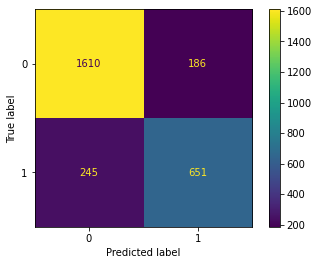

In [42]:
#Confusion Matrix

cm_xg = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xg,
                              display_labels=xg_clas.classes_)
disp.plot()

plt.show()

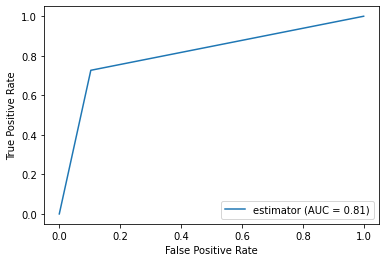

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='estimator')
display.plot()

plt.show()

In [46]:
print(xg_clas.feature_importances_)

[0.0053774  0.00713756 0.00494405 0.0057373  0.0048145  0.00531053
 0.00584216 0.00397674 0.0038596  0.00342062 0.06715208 0.0038975
 0.00629935 0.00880587 0.01455888 0.00615436 0.006019   0.00530489
 0.02211679 0.0050484  0.00175065 0.         0.00428457 0.00463438
 0.0052737  0.00431803 0.00640901 0.00703686 0.0044621  0.00501726
 0.00838937 0.00267322 0.00875506 0.00616752 0.00571562 0.00612181
 0.00479276 0.00391911 0.00700721 0.00646321 0.00407804 0.00768061
 0.00660112 0.00385595 0.00672571 0.00615947 0.0044974  0.00619517
 0.01132021 0.00458007 0.00599049 0.01009891 0.00525518 0.03068564
 0.00785806 0.00378875 0.00380886 0.         0.00576983 0.00869953
 0.00683612 0.         0.00687112 0.         0.01031729 0.0075725
 0.00716811 0.00714641 0.0095593  0.00779663 0.00743243 0.00511604
 0.00603266 0.00641029 0.00703403 0.00751496 0.         0.00478384
 0.00430139 0.0045537  0.0024635  0.0051071  0.00605238 0.00703338
 0.00590807 0.08740622 0.0047391  0.0066094  0.01559503 0.
 0.  

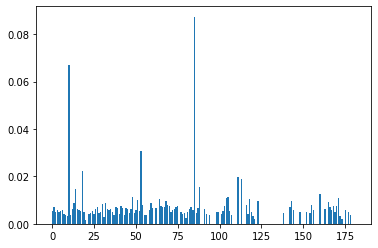

In [47]:
pyplot.bar(range(len(xg_clas.feature_importances_)), xg_clas.feature_importances_)
pyplot.show()

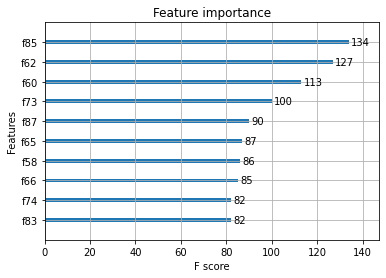

In [58]:
plot_importance(xg_clas,title='Feature importance', max_num_features=10)
pyplot.show()

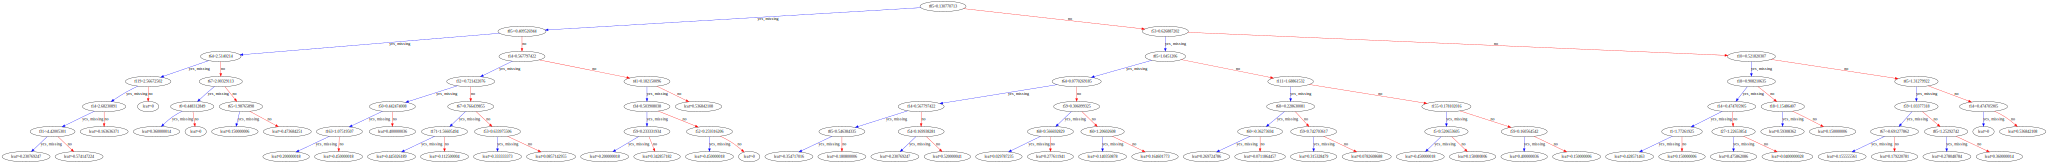

In [52]:
xgb.to_graphviz(xg_clas)